# Analyse d’un modèle avec demandes, stockage hydroélectrique et gaz

### Import des librairies utilisées pour résoudre les problèmes

In [379]:
import numpy as np
from fileData import FileData
import matplotlib.pyplot as plt

import cvxpy as cp
import importlib
import results
importlib.reload(results)

<module 'results' from '/Users/igor/PycharmProjects/LINMA1702/P2/results.py'>

### Variables communes

In [380]:
# Couts d'installation amortis des éoliennes
cout_instal_onshore  = 168903 # Coût *amorti sur un an* pour l'installation d'un MW éolien on-shore (euros/MW/an)
cout_instal_offshore = 300336 # Coût *amorti sur un an* pour l'installation d'un MW éolien on-shore (euros/MW/an)

# Couts d'installation amortis et coûts de fonctionnement des centrales au gaz
cout_instal_gaz = 94956 # Coût *amorti sur un an* pour l'installation d'un MW de centrale au gaz (euros/MW/an)
cout_fonct_gaz  = 65    # Coût de fonctionnement pour la production d'un MWh par centrale au gaz (euros/MWh)

# Stockage disponible par pays (en MWh)
stockage = [0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6]

# Puissances maximales de turbinage et de pompage disponibles par pays (en MW)
turbinage = [8587 , 12009 , 1417 , 9 , 18372 , 25132 , 527 , 21117 , 1140 , 28941 , 37 , 5052 , 4269 , 16637 , 15101]
pompage   = [5223 , 3580 , 1307 , 0 , 5347 , 4303 , 292 , 7544 , 1100 , 1396 , 0 , 1029 , 2744 , 45 , 1636 ]

# Rendement pour le turbinage (sans unité)
heta = 0.85

#Nombre d'éoliennes onshore et offshore
n_t = 487
n_m = 155
n = n_t + n_m

### Extraction des données partagées dans les modèles

In [381]:
data = FileData()

# Matrice de la consommation agrégée
Demandes = np.sum(data.getConsoData(), axis=0)
# Rendement des éoliennes onshore et offshore
Rendements = data.getRend()
# Capacités électriques éolien
c_t = data.getOnshoreCapacites()
c_m = data.getOffshoreCapacites()
c = np.concatenate((c_t,c_m))
# Apports naturels hydroélectriques agrégés
Water = np.sum(data.getHydroData(), axis=0)

### Variables temporelles

In [382]:
# Horizon temporel de résolution
"""
1 jour            : 24
1 semaine         : 168
1 mois (30 jours) : 720
3 mois (1/4 an)   : 2190
6 mois (1/2 an)   : 4380 
1 an   (365 jours): 8760
"""
h = 8760

# Longueur de la période utilisée
T = 3

# Nombre de périodes
t = h//T

In [383]:
# Réduction à l'horizon temporel considéré
D = Demandes[:h]
R = Rendements[:,:h]
W = Water[:h]

### Fonctions communes
Fonctions communes à tous les modèles

In [384]:
def periodisation(A, T):
    """
    Additionne toutes les valeurs de A dans une même période.
    input A : Matrice à périodiser
    !! Le nombre de colonnes (axis = 1) représente le temps (l'horizon temporel) !!
    input T : Longueur de la période
    output : Matrice A périodisée
    """
    # p : nombre de période
    # r : reste du nombre de période
    p = A.shape[1] // T
    r = A.shape[1] % T
    # On coupe la matrice car sinon il n'y a pas assez de données de remplir la dernière période
    A = A[:,:-r] if r!=0 else A
    # C : matrice pour additionner les productions d'une période
    C = np.zeros((A.shape[1], p))
    for i in range(p):
        C[i * T:(i + 1) * T, i] = 1
    # P : matrice périodisée
    P = np.dot(A, C)
    return P

def E_eolienne(R, c, T):
    A = np.zeros(R.shape)
    for i in range(len(c)):
        A[i] = c[i] * R[i]
        
    A = periodisation(A, T)
    return A

### Produits des fonctions communes
Variables communes nécessitant un calcul

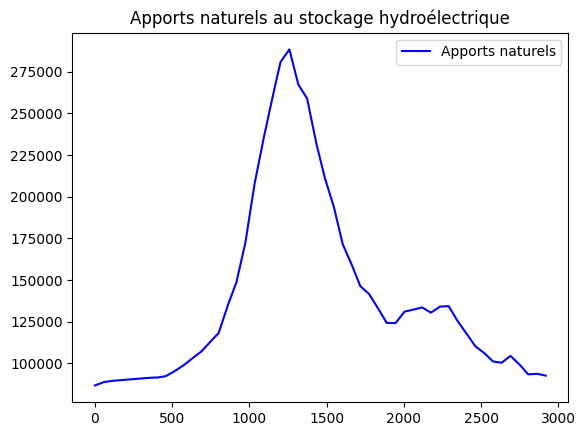

In [385]:
# Périodisation de D
d = periodisation(np.array([D]), T)
d = np.transpose(d)
# E : matrice de la production éolienne par site par période
E = E_eolienne(R, c, T)
# s : scalaire, stockage total hydroélectrique
s = np.sum(stockage)
# pPompage : scalaire, puissance de pompage totale
pPompage = np.sum(pompage)
# pTurbinage : scalaire, puissance de turbinage totale
pTurbinage = np.sum(turbinage)
# Périodisation de W
wA = periodisation(np.array([W]), T)
wA = np.transpose(wA)
# Matrice L
L = np.tril(np.ones((t,t)))

plt.plot(np.arange(t), wA, 'b', label="Apports naturels")
#plt.plot(np.arange(t), heta*T*pTurbinage*np.ones((t)), 'r', label="Max sortie")
plt.title("Apports naturels au stockage hydroélectrique")
plt.legend()
plt.show()

## Modèle 4
On considère d’abord un modèle européen agrégé avec installation d’éoliennes et utilisation des capacités hydroélectriques, mais pas de centrales au gaz. Ce modèle agrégé ne possède donc qu’une seule entité pour la production, le stockage et la consommation d’électricité (additionnez les capacités hydroélectriques et les demandes de tous les pays qui la composent).
On chercher à calculer la valeur minimale du prix moyen de l’électricité consommée.

### Resolution CVXPY
Nous résolvons le premier modèle en utilisant scipy à travers cvxpy

In [386]:
# Variables : portions des sites installés, quantités pompées, quantités turbinées
x = cp.Variable((n,1))
wP = cp.Variable((t,1))
wT = cp.Variable((t,1))

# Vecteur des prix d'installation d'éolienne onshore et offshore
cost = (h/8760)*np.concatenate((cout_instal_onshore * c_t, cout_instal_offshore * c_m))

# Contraintes
contraintes = [
    x >= 0, x <= 1, 
    E.T@x - wP + wT >= d,
    0 <= s/2 + L@(wA + wP - wT/heta), s/2 + L@(wA + wP - wT/heta) <= s,
    np.ones((1,t))@(wA + wP - wT/heta) == 0,
    0 <= wP, wP <= T*pPompage,
    0 <= wT, wT <= heta*T*pTurbinage,
    wP <= E.T@x
    ]

# Probleme
prob = cp.Problem(cp.Minimize(cost @ x), contraintes)


In [387]:
# Resolution
prob.solve(solver=cp.SCIPY)
print(prob.status)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/reductions/solvers/conic_solvers/scipy_conif.py:223: UserWarning: It is best to specify the 'method' parameter within scipy_options. The main advantage of this solver is its ability to use the HiGHS LP solvers via scipy.optimize.linprog(), which requires a SciPy version >= 1.6.1.

The default method 'highs' will be used in this case.

  warnings.warn("It is best to specify the 'method' parameter "


KeyboardInterrupt: 

In [ ]:
# Get values
prix_total = prob.value
x = x.value
wP = wP.value
wT = wT.value

# Vecteur d'énergie éolienne produite
e = E.T@x

# Capacités installées
cap_install = c@x

### Résultats

In [ ]:
results.print_values(prix_total, np.sum(e), np.sum(wA), np.sum(d))
results.occupation_bassin(t, s, wA, wP, wT)
results.sources_eng(t, e, wP, wT, d)

## Modèle 5
Considérons le modèle 4 avec la contrainte supplémentaire suivante : sur chaque site  éolien potentiel, il faut choisir entre installer 100%, 50% ou 0% de la capacité maximale installable.

In [ ]:
# Variables : portions des sites installés, quantités pompées, quantités turbinées
y = cp.Variable((n,1), integer=True)
x = y/2

wP = cp.Variable((t,1))
wT = cp.Variable((t,1))

# Vecteur des prix d'installation d'éolienne onshore et offshore
cost = (h/8760)*np.concatenate((cout_instal_onshore * c_t, cout_instal_offshore * c_m))

# Contraintes
contraintes = [
    E.T@(x) - wP + wT*heta >= d,
    0 <= s/2 + L@(wA + wP - wT), s/2 + L@(wA + wP - wT) <= s,
    np.ones((1,t))@(wA + wP - wT) == 0,
    0 <= wP, wP <= T*pPompage,
    0 <= wT, wT <= heta*T*pTurbinage,
    wP <= E.T@(x),
    0 <= y, y<= 2
    ]

# Problemex
prob = cp.Problem(cp.Minimize(cost @ (x)), contraintes)

In [ ]:
prob.solve(solver=cp.CBC)
print(prob.status)

In [ ]:
# Get values
prix_total = prob.value
wP = wP.value
wT = wT.value

# Vecteur d'énergie éolienne produite

e = E.T@x.value
# Capacités installées
cap_install = c@x.value

### Resultats

In [ ]:
results.print_values(prix_total, np.sum(e), np.sum(wA), np.sum(d))
results.occupation_bassin(t, s, wA, wP, wT)
results.sources_eng(t, e, wP, wT, d)

## Modèle 6
Revenons au modèle initial de la question 4 et incorporons la possibilité d’installer et d’utiliser des centrales au gaz.

## Résolution du problème

In [ ]:
# Variables : portions des sites installés, quantités pompées, quantités turbinées, puissance installée, énergie produite
x = cp.Variable((n,1))
wP = cp.Variable((t,1))
wT = cp.Variable((t,1))
pig = cp.Variable((1,1)) # puissance installée centrale au gaz (MW)
epg = cp.Variable((t,1)) # energie produite par période centrale au gaz (MWh)

# Vecteur des prix d'installation d'éolienne onshore et offshore
cost_eol = ((h/8760)*np.concatenate((cout_instal_onshore * c_t, cout_instal_offshore * c_m)))@x

# Prix d'installation et d'utilisation centrale au gaz
cig = (h/8760)*cout_instal_gaz*pig
cug = (cout_fonct_gaz*np.ones((1,t)))@epg

# Contraintes
contraintes = [
    x >= 0, x <= 1, 
    pig >= 0,
    epg >= 0,
    E.T@x - wP + wT*heta + epg >= d,
    0 <= s/2 + L@(wA + wP - wT), s/2 + L@(wA + wP - wT) <= s,
    np.ones((1,t))@(wA + wP - wT) == 0,
    0 <= wP, wP <= T*pPompage,
    0 <= wT, wT <= heta*T*pTurbinage,
    epg <= T*pig,
    wP <= E.T@x + epg
    ]

# Probleme
prob = cp.Problem(cp.Minimize(cost_eol + cig + cug), contraintes)


In [ ]:
# Resolution
prob.solve(solver=cp.SCIPY)
print(prob.status)

In [ ]:
# Get values
prix_total = prob.value
x = x.value
wP = wP.value
wT = wT.value
pig = pig.value
epg = epg.value

# Vecteur d'énergie éolienne produite
e = E.T@x

# Capacités installées
cap_install = c@x

### Résultats

In [ ]:
results.print_values(prix_total, np.sum(e), np.sum(wA), np.sum(d), e_gaz_produite=np.sum(epg))
results.occupation_bassin(t, s, wA, wP, wT)
results.sources_eng(t, e, wP, wT, d, epg=epg)